<h1><center>Titanic - Machine Learning from Disaster</center></h1>

This project is based on [Kaggle challenge](https://www.kaggle.com/c/titanic/overview) and tried to answear the following question:
> **What sorts of people were more likely to survive?**

# Importing libs

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
%matplotlib inline
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
import cufflinks as cf

# Getting dataset

In [2]:
df_train = pd.read_csv('train.csv')

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df_train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


# Exploratory Data Analysis

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Analysing null values

In [6]:
#df_train['Fare'].value_counts()

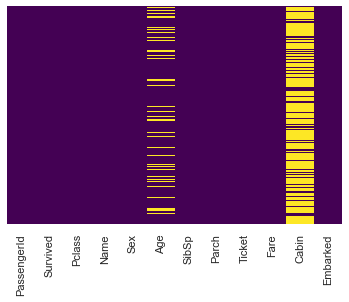

In [7]:
sns.heatmap(df_train.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

**Comment #1**: There are missing values in *Age* column and *Cabin* column. Most of the values from *Cabin* are missing and we can drop this column as we already have information about the passenger socio-economic class.

**Comment #2**: The *Age* column could be a good indicator about what sort of passenger were more likely to survive. So we take a look at this column.

In [8]:
percentage_age_null =(df_train['Age'].isnull().sum()/df_train['Age'].size)*100
print(f"Percentage of null values in Age column: {round(percentage_age_null, 2)}%")

Percentage of null values in Age column: 19.87%


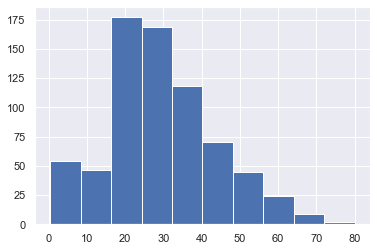

In [9]:
df_train['Age'].hist()
plt.show()

In [10]:
df_train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [11]:
df_train['Age'].median()

28.0

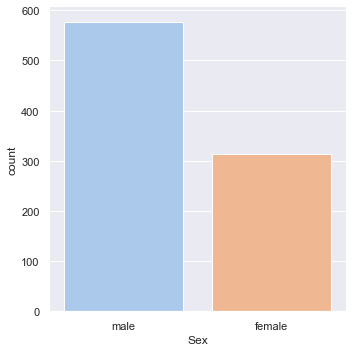

In [12]:
sns.catplot(x= 'Sex',data=df_train,kind='count',palette='pastel')

#### Almost 2/3 of the all passenger in Titanic were men

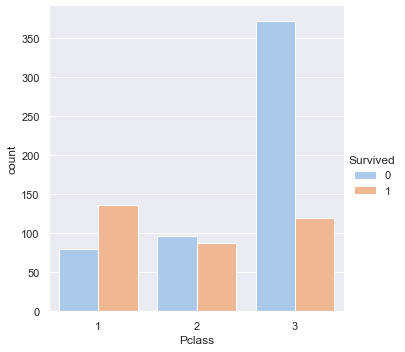

In [13]:
sns.catplot(x= 'Pclass',hue='Survived',data=df_train,kind='count',palette='pastel')

In [14]:
### Quantidade relativa de sobreviventes

In [15]:
df_train.groupby('Survived')['Pclass'].value_counts(normalize=True)

Survived  Pclass
0         3         0.677596
          2         0.176685
          1         0.145719
1         1         0.397661
          3         0.347953
          2         0.254386
Name: Pclass, dtype: float64

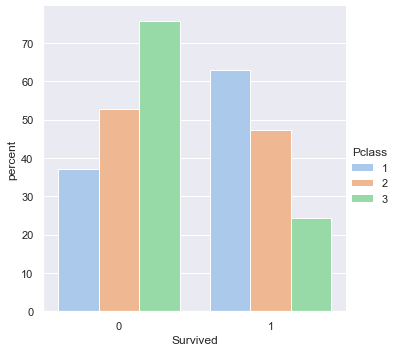

In [16]:
df_train.groupby('Pclass')['Survived'].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x='Survived',y='percent',hue='Pclass',kind='bar',palette='pastel')

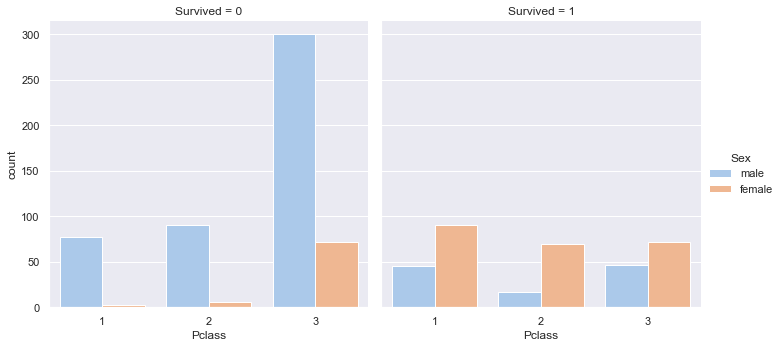

In [17]:
sns.set(color_codes=True)
sns.catplot(x='Pclass', hue='Sex',col='Survived', 
            data=df_train, kind='count',palette='pastel')


<AxesSubplot:xlabel='SibSp', ylabel='count'>

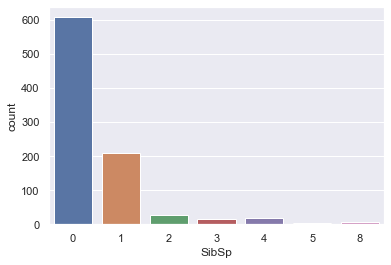

In [18]:
sns.countplot(x='SibSp',data=df_train)

#### Most of the people are alone or probably with a husband/wife or a child

### Quantas pessoas sozinhas estavam no Titanic?

In [19]:
single = df_train[df_train['SibSp'] == 0][df_train['Parch'] == 0]

C:\Users\NATHAL~1.BED\AppData\Local\Temp/ipykernel_58988/995864640.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



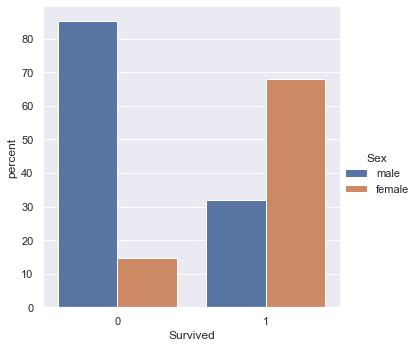

In [20]:
df_train.groupby('Survived')['Sex'].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x='Survived',y='percent',hue='Sex',kind='bar')

# Data Cleaning

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

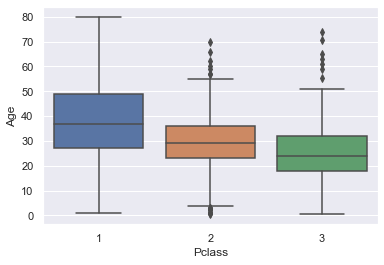

In [21]:
sns.boxplot(x='Pclass',y='Age',data=df_train)

In [22]:
df_train[df_train['Pclass'] == 1]['Age'].mean()

38.233440860215055

In [23]:
df_train[df_train['Pclass'] == 2]['Age'].mean()

29.87763005780347

In [24]:
df_train[df_train['Pclass'] == 3]['Age'].mean()

25.14061971830986

In [25]:
avg = {ind: df_train[df_train['Pclass'] == ind]['Age'].mean() for ind in df_train['Pclass'].value_counts().index}

In [26]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return avg[Pclass]
        
        elif Pclass == 2:
            return avg[Pclass]
        
        else:
            return avg[Pclass]
        
    else: 
        return Age

In [27]:
df_train['Age'] = df_train[['Age','Pclass']].apply(impute_age,axis=1)

<AxesSubplot:>

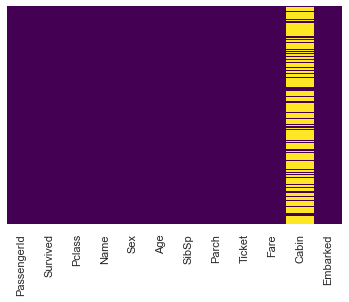

In [28]:
sns.heatmap(df_train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [29]:
sex = pd.get_dummies(df_train['Sex'],drop_first=True)
embark = pd.get_dummies(df_train['Embarked'],drop_first=True)

In [30]:
embark

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1
...,...,...
886,0,1
887,0,1
888,0,1
889,0,0


In [31]:
sex

,male
0,1
1,0
2,0
3,0
4,1
...,...
886,1
887,0
888,0
889,1


In [32]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
X, y = load_iris(return_X_y=True)

In [33]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])